In [1]:
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [28]:
import numpy as np
from csv import reader
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models
import torchvision.transforms as F
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
from sklearn.metrics import *

In [3]:
FILENAME = '/content/drive/MyDrive/code/AIBase/project2/表情识别.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### 超参数

In [4]:
max_epoch = 100
batch_size = 64
learning_rate = 0.001

### 读取文件，导入数据

In [5]:
def LoadData():
    with open(FILENAME, 'rt', encoding='UTF-8') as raw_data:
        readers = reader(raw_data)
        data = np.array(list(readers))
    # data.shape: (35888, 3)
    # train
    data_train_raw = data[data[:, 2] == 'Training']
    input_train = np.array([np.array(list(map(int, data_train_raw[i][1].strip().split()))).reshape(48, 48) 
                            for i in range(len(data_train_raw))])
    label_train = np.array([int(data_train_raw[i][0])
                            for i in range(len(data_train_raw))])
    # test
    data_test_raw = data[data[:, 2] == 'Test']
    input_test = np.array([np.array(list(map(int, data_test_raw[i][1].strip().split()))).reshape(48, 48)
                            for i in range(len(data_test_raw))])
    label_test = np.array([int(data_test_raw[i][0])
                            for i in range(len(data_test_raw))])
    return input_train, label_train, input_test, label_test

In [6]:
# Load Data
InputTrain, LabelTrain, InputTest, LabelTest = LoadData()

In [7]:
class MyDataSet(Dataset):
    def __init__(self, img, label, transform=None):
        super(MyDataSet, self).__init__()
        self.img = img
        self.label = label
        self.transform = transform

    def __getitem__(self, index):
        img = Image.fromarray(np.uint8(self.img[index]))
        if self.transform is not None:
            img = self.transform(img)
        label = self.label[index]
        img = np.asarray(img)
        # img = np.expand_dims(img, 0)

        return img, label

    def __len__(self):
        return len(self.img)

In [8]:
train_trans = F.Compose([
                F.RandomApply([F.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
                F.RandomHorizontalFlip(),
                F.RandomApply([F.RandomRotation(10)], p=0.5),
                F.RandomCrop(48, 4),
                F.ToTensor(),
                # F.Pad(4),
                # F.TenCrop(48),
                # F.Lambda(lambda crops: torch.stack([F.ToTensor()(crop) for crop in crops])),
                # # F.Lambda(lambda tensors: torch.stack([F.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
                # F.Lambda(lambda tensors: torch.stack([F.RandomErasing(p=0.5)(t) for t in tensors])),
                ])
test_trans = F.Compose([
                F.ToTensor(),
                # F.Pad(4),
                # F.TenCrop(48),
                # F.Lambda(lambda crops: torch.stack([F.ToTensor()(crop) for crop in crops])),
                ])
data_train = MyDataSet(InputTrain, LabelTrain, train_trans)
print(len(data_train))
data_test = MyDataSet(InputTest, LabelTest, test_trans)
print(len(data_test))

28709
7178


In [9]:
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(data_test, batch_size=batch_size)
# 48 x 48

### 训练函数

In [10]:
def Train(model, criterion, optimizer, max_epoch):
    # Train mode
    model.train()
    # to record the change(to be drawn)
    loss_list, accu_list = [], []
    for epoch in range(max_epoch):
        accu_num = 0
        loss_sum = 0
        # one epoch
        for data, label in loader_train:
            data, label = data.to(DEVICE), label.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            # 更新
            optimizer.step()
            # 放回cpu
            loss_sum += loss.cpu().item()
            predict = torch.argmax(output, dim=1)
            accu_num += (predict == label).sum().item()
        
        epoch_loss = loss_sum / len(loader_train.dataset)
        epoch_accu = accu_num / len(loader_train.dataset)
        print("epoch {}: loss: {:.6f}, train accuracy: {:.6f}".format(epoch, epoch_loss, epoch_accu))
        loss_list.append(epoch_loss)
        accu_list.append(epoch_accu)
    return loss_list, accu_list

### 测试函数

In [11]:
def Test(model):
    # mode
    model.eval()
    accu_num = 0
    with torch.no_grad():
        for idx, (data, label) in enumerate(loader_test):
            data, label = data.to(DEVICE), label.to(DEVICE)
            output = model(data)
            accu_num += torch.sum(torch.argmax(output, dim=1) == label.data)
    accu_num = accu_num.cpu().item()
    test_accu = accu_num / len(loader_test.dataset)
    print("test accuracy:", test_accu)

    return test_accu

### 绘画函数

In [13]:
def Draw(loss_list, accuracy_list, test_list=[1]):
    plt.subplot(211)
    epoch_list = [i for i in range(len(loss_list))]
    plt.plot(epoch_list, loss_list, label='loss', c='r')
    plt.legend()
    plt.subplot(212)
    plt.plot(epoch_list, accuracy_list, label='accuracy', c='b')
    # plt.tight_layout()
    plt.legend()
    plt.show()
    plt.subplot(111)
    tx = [i for i in range(len(test_list))]
    plt.plot(tx, test_list, label='test', c='g')
    plt.legend()
    plt.show()

### model

In [14]:
def gaussian_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and classname.find('Conv') == 0:
        m.weight.data.normal_(0.0, 0.02)

class ERNet(nn.Module):
    # 初始化网络结构
    def __init__(self, crop_flag=False):
        super(ERNet, self).__init__()
        self.crop_flag = crop_flag
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),  # [64, 48, 48]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Dropout(p=0.2), # [64, 24, 24]

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.Conv2d(128, 128, 3, 1, 1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
            nn.Dropout(p=0.2),   # [128, 12, 12]
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Conv2d(256, 256, 3, 1, 1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
            nn.Dropout(p=0.2),   # [256, 6, 6]
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.Conv2d(512, 512, 3, 1, 1),
            # nn.BatchNorm2d(512),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
            nn.Dropout(p=0.3),  # [512, 3, 3]
        )

        self.fc = nn.Sequential(  #fully connected layers
            nn.Linear(512 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 7),
        )

        self.cnn.apply(gaussian_weights_init)
        self.fc.apply(gaussian_weights_init)

    def forward(self, x):
        if self.crop_flag:
            bs, ncrops, c, h, w = x.size()
            x = x.view(-1, c, h, w)
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        if self.crop_flag:
            out = out.view(bs, ncrops, -1).mean(1)
        return out

### Train&Test

epoch 0: loss: 0.028968, train accuracy: 0.242677
epoch 1: loss: 0.027703, train accuracy: 0.270229
epoch 2: loss: 0.025713, train accuracy: 0.328225
epoch 3: loss: 0.024106, train accuracy: 0.382075
epoch 4: loss: 0.023182, train accuracy: 0.410638
test accuracy: 0.48021733073279466


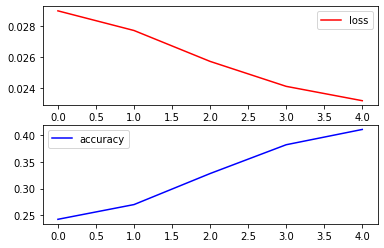

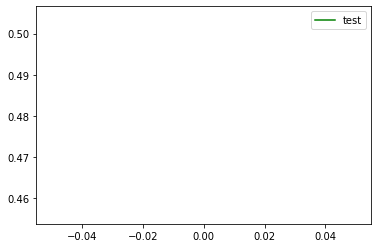

epoch 0: loss: 0.022414, train accuracy: 0.426835
epoch 1: loss: 0.021942, train accuracy: 0.445714
epoch 2: loss: 0.021449, train accuracy: 0.461528
epoch 3: loss: 0.021177, train accuracy: 0.464105
epoch 4: loss: 0.020838, train accuracy: 0.471908
test accuracy: 0.5401225968236277


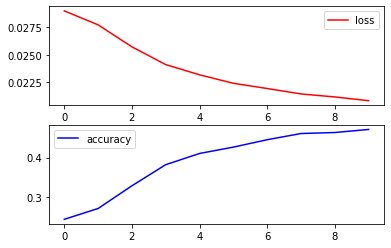

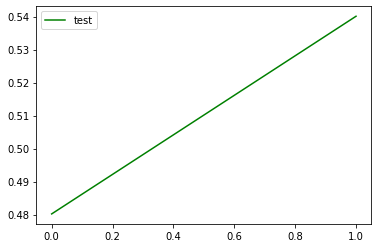

epoch 0: loss: 0.020551, train accuracy: 0.487687
epoch 1: loss: 0.020392, train accuracy: 0.484517
epoch 2: loss: 0.020067, train accuracy: 0.495629
epoch 3: loss: 0.020005, train accuracy: 0.496534
epoch 4: loss: 0.019808, train accuracy: 0.506287
test accuracy: 0.5618556701030928


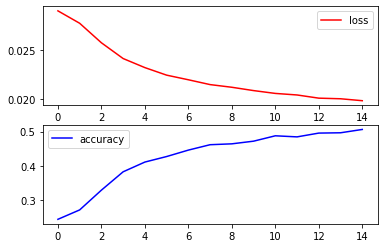

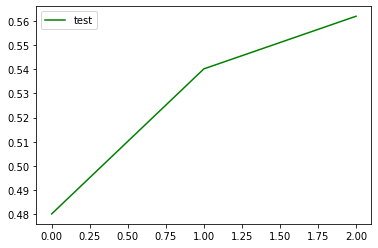

epoch 0: loss: 0.019707, train accuracy: 0.506670
epoch 1: loss: 0.019599, train accuracy: 0.512836
epoch 2: loss: 0.019252, train accuracy: 0.525410
epoch 3: loss: 0.019063, train accuracy: 0.526664
epoch 4: loss: 0.019113, train accuracy: 0.531645
test accuracy: 0.5912510448592923


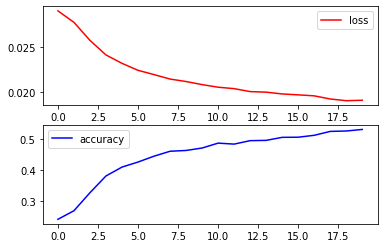

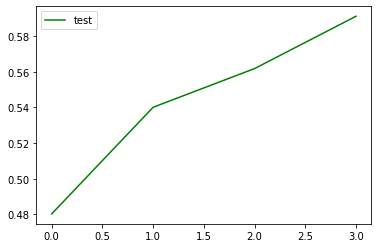

epoch 0: loss: 0.018862, train accuracy: 0.541398
epoch 1: loss: 0.018728, train accuracy: 0.540318
epoch 2: loss: 0.018687, train accuracy: 0.545439
epoch 3: loss: 0.018430, train accuracy: 0.554007
epoch 4: loss: 0.018281, train accuracy: 0.557317
test accuracy: 0.5977988297575927


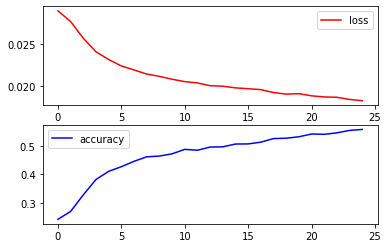

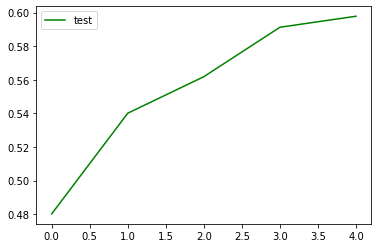

epoch 0: loss: 0.018186, train accuracy: 0.557526
epoch 1: loss: 0.017933, train accuracy: 0.566338
epoch 2: loss: 0.017742, train accuracy: 0.571842
epoch 3: loss: 0.017559, train accuracy: 0.575569
epoch 4: loss: 0.017246, train accuracy: 0.586680
test accuracy: 0.6192532738924491


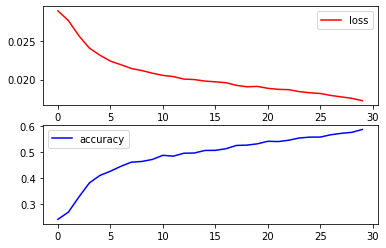

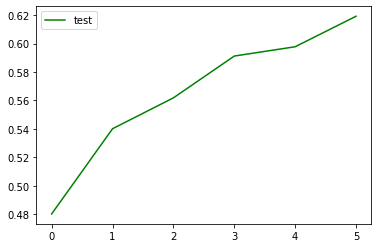

epoch 0: loss: 0.017043, train accuracy: 0.593647
epoch 1: loss: 0.016912, train accuracy: 0.595946
epoch 2: loss: 0.016808, train accuracy: 0.596120
epoch 3: loss: 0.016632, train accuracy: 0.603434
epoch 4: loss: 0.016417, train accuracy: 0.605072
test accuracy: 0.6309556979660073


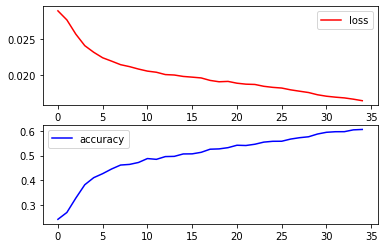

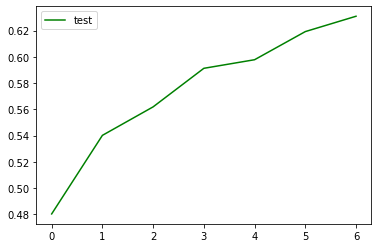

epoch 0: loss: 0.016475, train accuracy: 0.605629
epoch 1: loss: 0.016327, train accuracy: 0.610645
epoch 2: loss: 0.016271, train accuracy: 0.613780
epoch 3: loss: 0.015996, train accuracy: 0.620990
epoch 4: loss: 0.015959, train accuracy: 0.620676
test accuracy: 0.6355530788520479


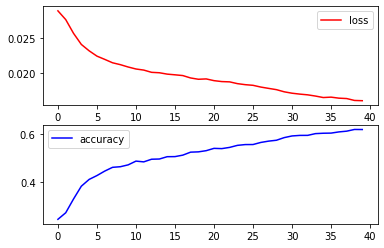

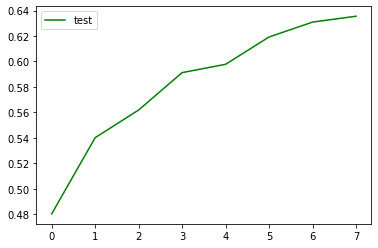

epoch 0: loss: 0.015965, train accuracy: 0.621547
epoch 1: loss: 0.015765, train accuracy: 0.624578
epoch 2: loss: 0.015725, train accuracy: 0.627120
epoch 3: loss: 0.015615, train accuracy: 0.628862
epoch 4: loss: 0.015517, train accuracy: 0.634052
test accuracy: 0.6476734466425188


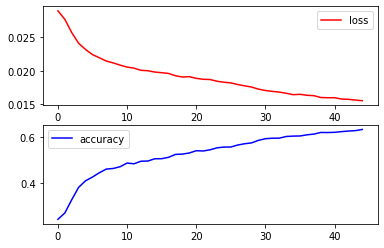

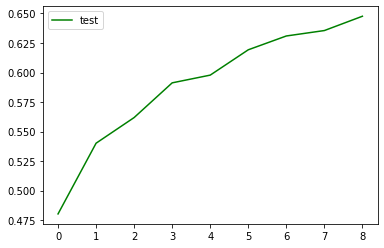

epoch 0: loss: 0.015423, train accuracy: 0.635863
epoch 1: loss: 0.015202, train accuracy: 0.641645
epoch 2: loss: 0.015137, train accuracy: 0.640322
epoch 3: loss: 0.015087, train accuracy: 0.645268
epoch 4: loss: 0.014995, train accuracy: 0.645791
test accuracy: 0.6497631652270828


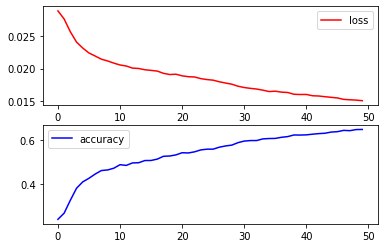

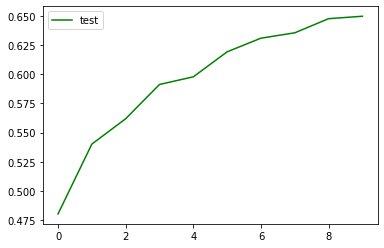

epoch 0: loss: 0.014976, train accuracy: 0.648612
epoch 1: loss: 0.014838, train accuracy: 0.646661
epoch 2: loss: 0.014828, train accuracy: 0.650423
epoch 3: loss: 0.014716, train accuracy: 0.651538
epoch 4: loss: 0.014529, train accuracy: 0.657320
test accuracy: 0.6560323209807746


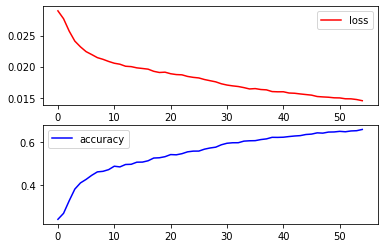

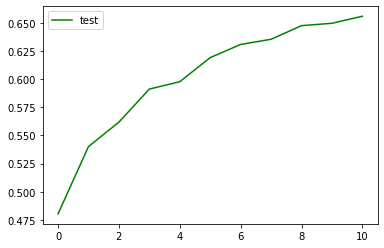

epoch 0: loss: 0.014519, train accuracy: 0.656275
epoch 1: loss: 0.014529, train accuracy: 0.653001
epoch 2: loss: 0.014325, train accuracy: 0.661988
epoch 3: loss: 0.014261, train accuracy: 0.663485
epoch 4: loss: 0.014225, train accuracy: 0.658922
test accuracy: 0.673168013374199


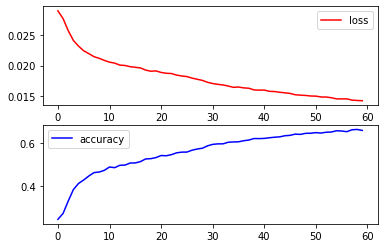

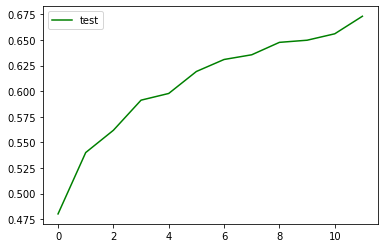

epoch 0: loss: 0.014147, train accuracy: 0.666899
epoch 1: loss: 0.013953, train accuracy: 0.668466
epoch 2: loss: 0.013894, train accuracy: 0.670347
epoch 3: loss: 0.013900, train accuracy: 0.671114
epoch 4: loss: 0.013917, train accuracy: 0.669546
test accuracy: 0.6723321259403734


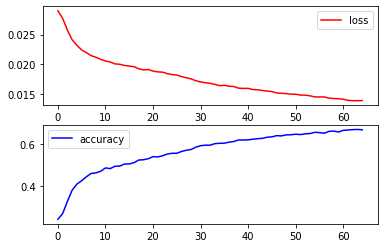

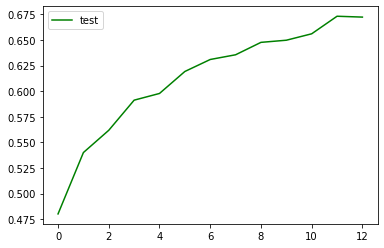

epoch 0: loss: 0.013758, train accuracy: 0.675642
epoch 1: loss: 0.013775, train accuracy: 0.671671
epoch 2: loss: 0.013874, train accuracy: 0.670417
epoch 3: loss: 0.013592, train accuracy: 0.677801
epoch 4: loss: 0.013522, train accuracy: 0.679195
test accuracy: 0.6748397882418501


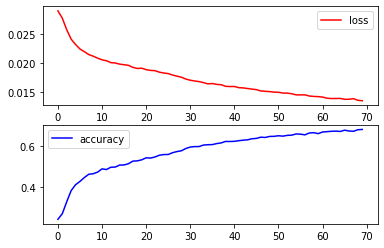

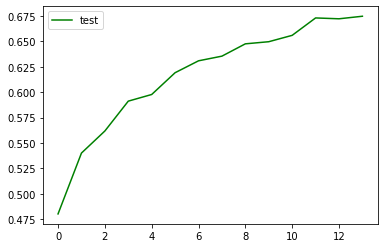

epoch 0: loss: 0.013438, train accuracy: 0.682573
epoch 1: loss: 0.013470, train accuracy: 0.680065
epoch 2: loss: 0.013348, train accuracy: 0.685813
epoch 3: loss: 0.013343, train accuracy: 0.681145
epoch 4: loss: 0.013254, train accuracy: 0.685882
test accuracy: 0.6769295068264141


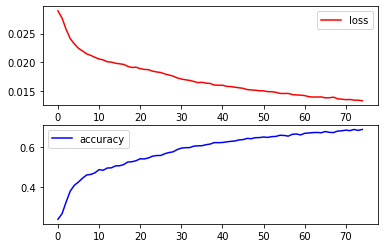

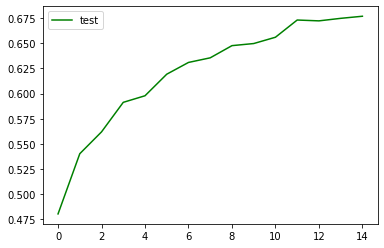

epoch 0: loss: 0.013273, train accuracy: 0.680936
epoch 1: loss: 0.013191, train accuracy: 0.686649
epoch 2: loss: 0.013125, train accuracy: 0.687067
epoch 3: loss: 0.013082, train accuracy: 0.686196
epoch 4: loss: 0.012966, train accuracy: 0.692048
test accuracy: 0.6765115631095012


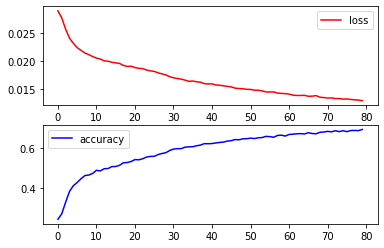

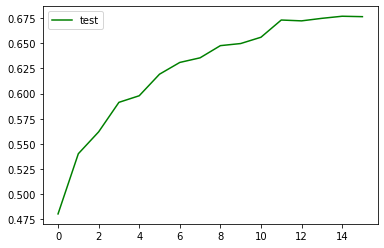

epoch 0: loss: 0.013014, train accuracy: 0.691177
epoch 1: loss: 0.012921, train accuracy: 0.692083
epoch 2: loss: 0.012833, train accuracy: 0.695427
epoch 3: loss: 0.012791, train accuracy: 0.696820
epoch 4: loss: 0.012800, train accuracy: 0.694695
test accuracy: 0.6770688213987183


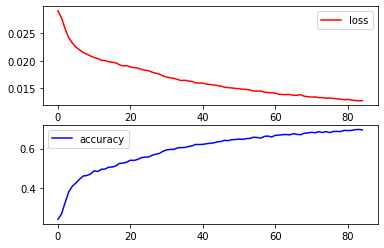

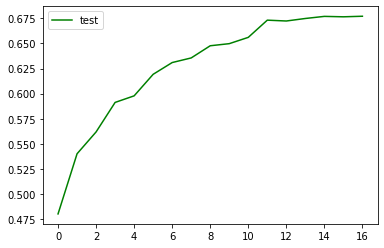

epoch 0: loss: 0.012635, train accuracy: 0.698109
epoch 1: loss: 0.012724, train accuracy: 0.696924
epoch 2: loss: 0.012627, train accuracy: 0.698178
epoch 3: loss: 0.012609, train accuracy: 0.698840
epoch 4: loss: 0.012539, train accuracy: 0.697586
test accuracy: 0.6781833379771524


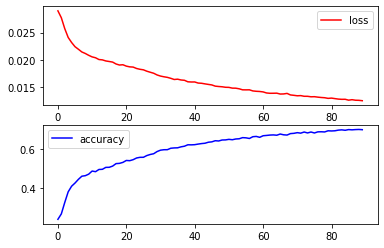

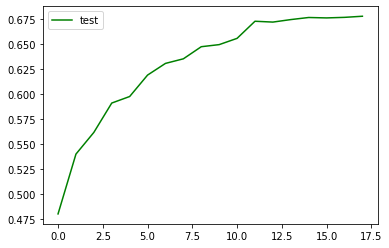

epoch 0: loss: 0.012519, train accuracy: 0.702881
epoch 1: loss: 0.012405, train accuracy: 0.704657
epoch 2: loss: 0.012419, train accuracy: 0.701418
epoch 3: loss: 0.012367, train accuracy: 0.705040
epoch 4: loss: 0.012258, train accuracy: 0.707687
test accuracy: 0.6819448314293675


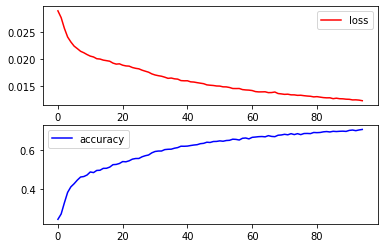

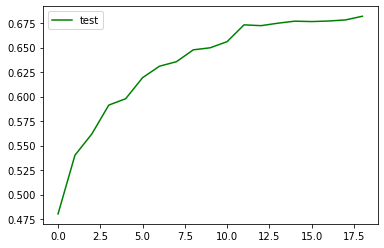

epoch 0: loss: 0.012247, train accuracy: 0.710857
epoch 1: loss: 0.012225, train accuracy: 0.708349
epoch 2: loss: 0.012134, train accuracy: 0.711345
epoch 3: loss: 0.012276, train accuracy: 0.706434
epoch 4: loss: 0.012072, train accuracy: 0.712146
test accuracy: 0.6841738645862357


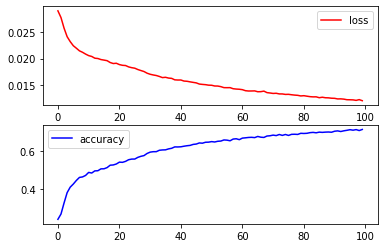

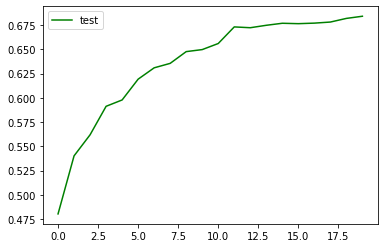

epoch 0: loss: 0.012020, train accuracy: 0.713957
epoch 1: loss: 0.011964, train accuracy: 0.714863
epoch 2: loss: 0.012079, train accuracy: 0.715072
epoch 3: loss: 0.012085, train accuracy: 0.714515
epoch 4: loss: 0.011861, train accuracy: 0.715838
test accuracy: 0.6912789077737531


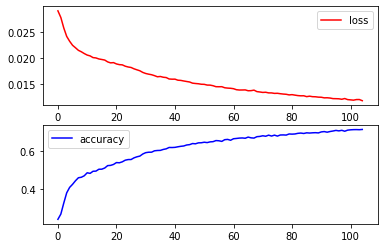

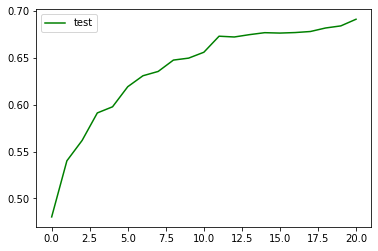

epoch 0: loss: 0.011910, train accuracy: 0.714898
epoch 1: loss: 0.011915, train accuracy: 0.717963
epoch 2: loss: 0.011875, train accuracy: 0.715734
epoch 3: loss: 0.011806, train accuracy: 0.720192
epoch 4: loss: 0.011769, train accuracy: 0.717789
test accuracy: 0.6923934243521872


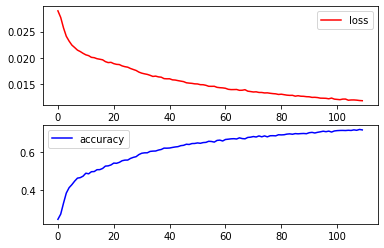

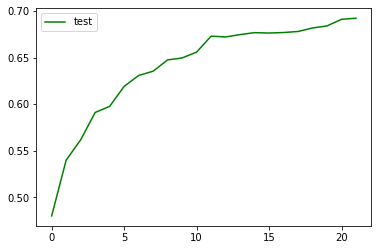

epoch 0: loss: 0.011682, train accuracy: 0.721899
epoch 1: loss: 0.011665, train accuracy: 0.722735
epoch 2: loss: 0.011569, train accuracy: 0.723954
epoch 3: loss: 0.011678, train accuracy: 0.719844
epoch 4: loss: 0.011488, train accuracy: 0.723884
test accuracy: 0.6827807188631931


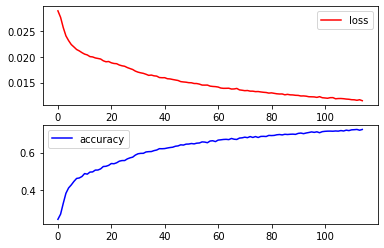

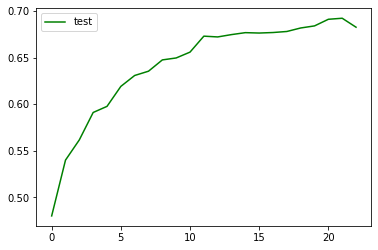

epoch 0: loss: 0.011551, train accuracy: 0.725138
epoch 1: loss: 0.011586, train accuracy: 0.723641
epoch 2: loss: 0.011522, train accuracy: 0.724477
epoch 3: loss: 0.011414, train accuracy: 0.723919
epoch 4: loss: 0.011420, train accuracy: 0.726706
test accuracy: 0.6935079409306213


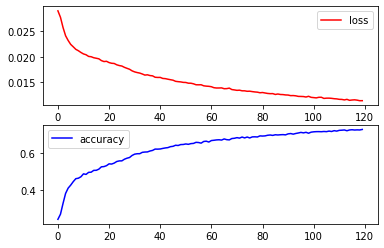

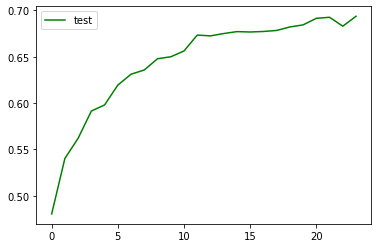

epoch 0: loss: 0.011403, train accuracy: 0.730572
epoch 1: loss: 0.011383, train accuracy: 0.730955
epoch 2: loss: 0.011360, train accuracy: 0.727681
epoch 3: loss: 0.011291, train accuracy: 0.730119
epoch 4: loss: 0.011258, train accuracy: 0.730816
test accuracy: 0.6908609640568404


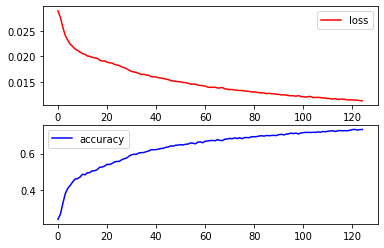

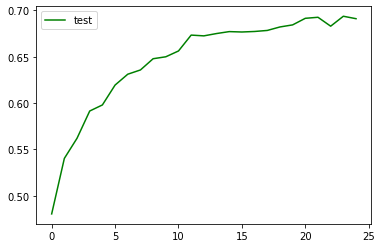

epoch 0: loss: 0.011156, train accuracy: 0.735309
epoch 1: loss: 0.011212, train accuracy: 0.729562
epoch 2: loss: 0.011139, train accuracy: 0.738096
epoch 3: loss: 0.011095, train accuracy: 0.733916
epoch 4: loss: 0.011063, train accuracy: 0.739629
test accuracy: 0.7031206464196155


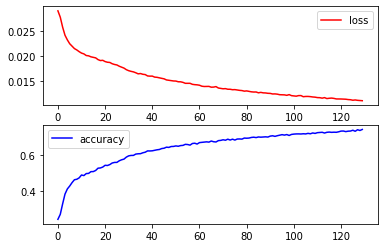

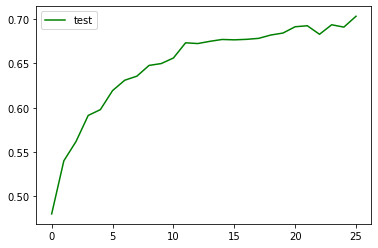

epoch 0: loss: 0.011072, train accuracy: 0.737678
epoch 1: loss: 0.011013, train accuracy: 0.736668
epoch 2: loss: 0.011015, train accuracy: 0.735727
epoch 3: loss: 0.010957, train accuracy: 0.736981
epoch 4: loss: 0.010931, train accuracy: 0.739037
test accuracy: 0.6921147952075787


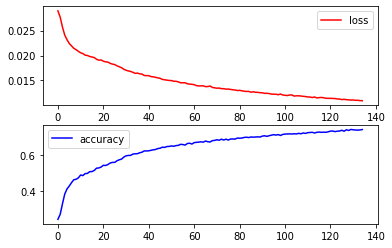

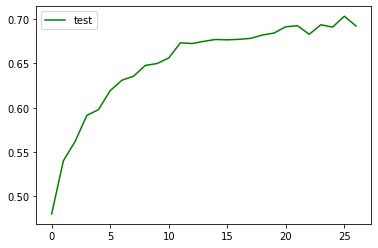

epoch 0: loss: 0.010957, train accuracy: 0.736633
epoch 1: loss: 0.010969, train accuracy: 0.740743
epoch 2: loss: 0.010840, train accuracy: 0.740604
epoch 3: loss: 0.010852, train accuracy: 0.740952
epoch 4: loss: 0.010736, train accuracy: 0.744052
test accuracy: 0.6969908052382279


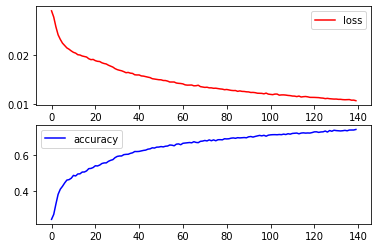

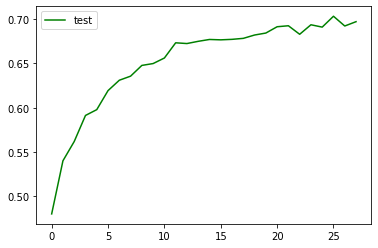

epoch 0: loss: 0.010748, train accuracy: 0.744157
epoch 1: loss: 0.010700, train accuracy: 0.746003
epoch 2: loss: 0.010649, train accuracy: 0.746282
epoch 3: loss: 0.010669, train accuracy: 0.745968
epoch 4: loss: 0.010622, train accuracy: 0.745759
test accuracy: 0.6996377821120089


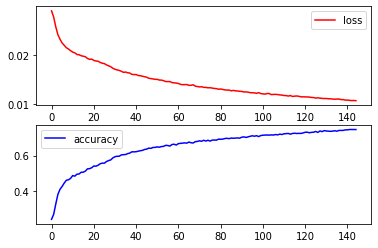

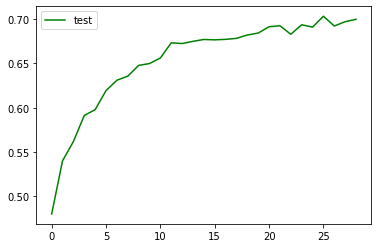

epoch 0: loss: 0.010641, train accuracy: 0.744958
epoch 1: loss: 0.010634, train accuracy: 0.747361
epoch 2: loss: 0.010616, train accuracy: 0.745864
epoch 3: loss: 0.010547, train accuracy: 0.749312
epoch 4: loss: 0.010530, train accuracy: 0.748894
test accuracy: 0.7011702424073558


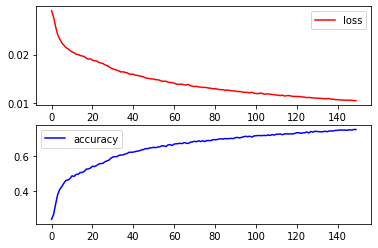

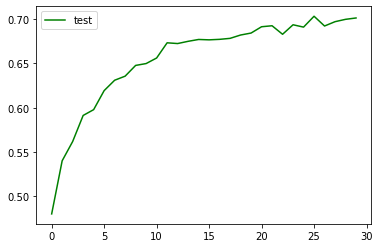

epoch 0: loss: 0.010469, train accuracy: 0.748999
epoch 1: loss: 0.010391, train accuracy: 0.749486
epoch 2: loss: 0.010451, train accuracy: 0.750845
epoch 3: loss: 0.010392, train accuracy: 0.748476
epoch 4: loss: 0.010425, train accuracy: 0.752482
test accuracy: 0.7036779047088325


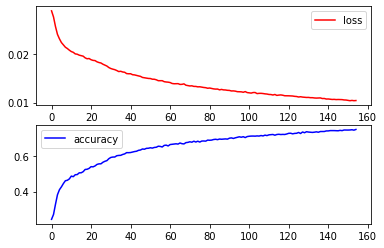

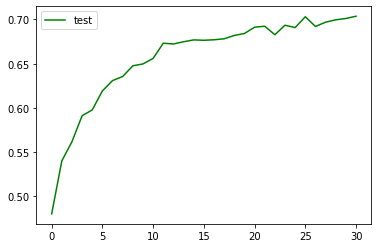

epoch 0: loss: 0.010432, train accuracy: 0.749173
epoch 1: loss: 0.010273, train accuracy: 0.754293
epoch 2: loss: 0.010265, train accuracy: 0.755547
epoch 3: loss: 0.010426, train accuracy: 0.752168
epoch 4: loss: 0.010272, train accuracy: 0.751332
test accuracy: 0.7025633881303984


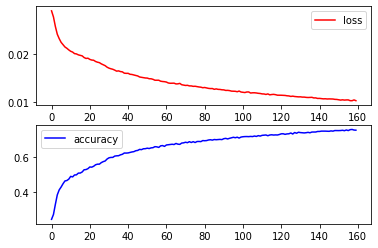

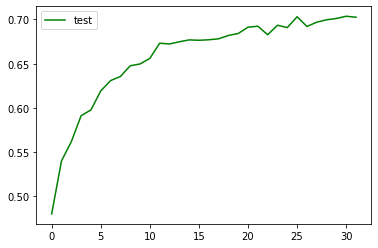

epoch 0: loss: 0.010362, train accuracy: 0.753213
epoch 1: loss: 0.010204, train accuracy: 0.755930
epoch 2: loss: 0.010152, train accuracy: 0.755582
epoch 3: loss: 0.010240, train accuracy: 0.757532
epoch 4: loss: 0.010168, train accuracy: 0.760075
test accuracy: 0.703399275564224


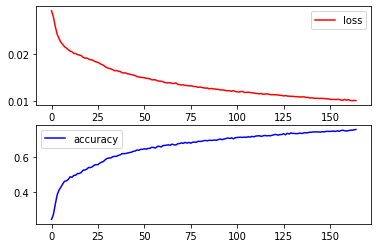

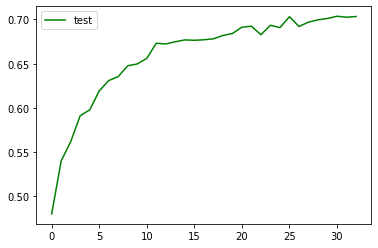

epoch 0: loss: 0.010134, train accuracy: 0.756940
epoch 1: loss: 0.010032, train accuracy: 0.761503
epoch 2: loss: 0.010153, train accuracy: 0.755164
epoch 3: loss: 0.010017, train accuracy: 0.763071
epoch 4: loss: 0.010066, train accuracy: 0.758543
test accuracy: 0.7053496795764836


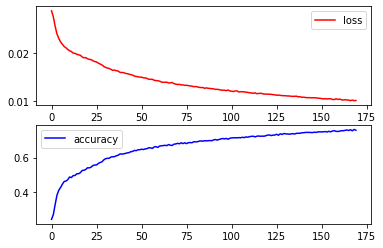

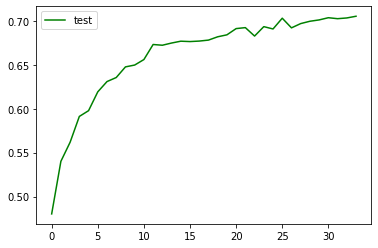

epoch 0: loss: 0.010071, train accuracy: 0.758577
epoch 1: loss: 0.009845, train accuracy: 0.763593
epoch 2: loss: 0.009948, train accuracy: 0.762165
epoch 3: loss: 0.009867, train accuracy: 0.763942
epoch 4: loss: 0.009952, train accuracy: 0.761469
test accuracy: 0.706046252438005


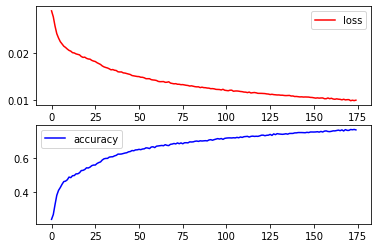

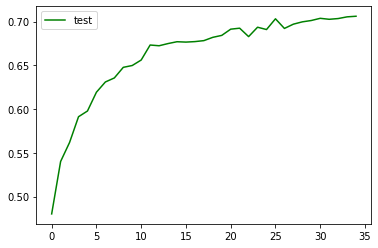

epoch 0: loss: 0.009879, train accuracy: 0.764569
epoch 1: loss: 0.009856, train accuracy: 0.765230
epoch 2: loss: 0.009876, train accuracy: 0.768679
epoch 3: loss: 0.009966, train accuracy: 0.762374
epoch 4: loss: 0.009951, train accuracy: 0.765439
test accuracy: 0.7067428252995264


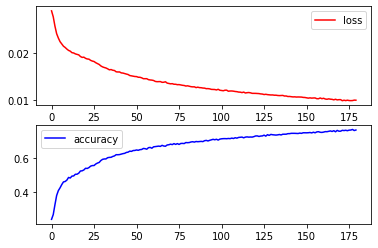

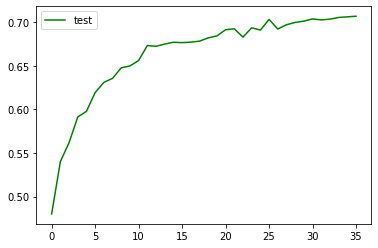

epoch 0: loss: 0.009749, train accuracy: 0.766868
epoch 1: loss: 0.009818, train accuracy: 0.763280
epoch 2: loss: 0.009707, train accuracy: 0.767982
epoch 3: loss: 0.009757, train accuracy: 0.766554
epoch 4: loss: 0.009757, train accuracy: 0.765857
test accuracy: 0.7053496795764836


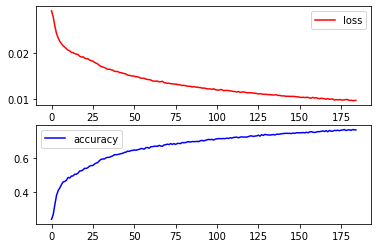

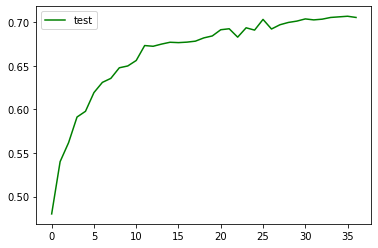

epoch 0: loss: 0.009657, train accuracy: 0.767146
epoch 1: loss: 0.009616, train accuracy: 0.771396
epoch 2: loss: 0.009656, train accuracy: 0.767704
epoch 3: loss: 0.009554, train accuracy: 0.771222
epoch 4: loss: 0.009544, train accuracy: 0.773242
test accuracy: 0.7024240735580942


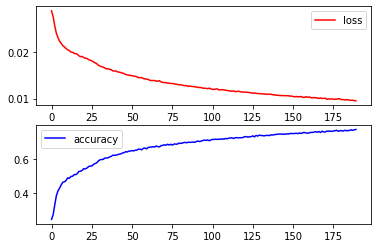

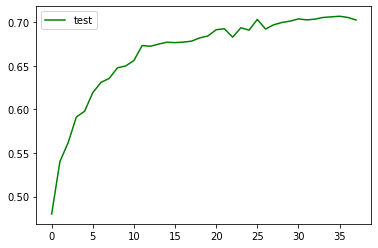

epoch 0: loss: 0.009635, train accuracy: 0.771953
epoch 1: loss: 0.009548, train accuracy: 0.773660
epoch 2: loss: 0.009596, train accuracy: 0.770072
epoch 3: loss: 0.009528, train accuracy: 0.772685
epoch 4: loss: 0.009478, train accuracy: 0.774217
test accuracy: 0.6997770966843132


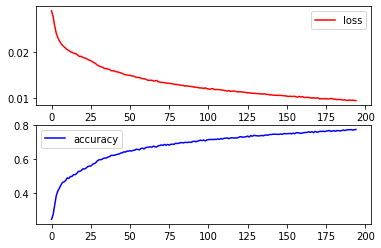

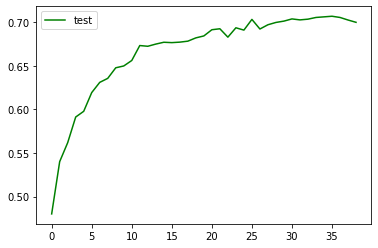

epoch 0: loss: 0.009403, train accuracy: 0.774983
epoch 1: loss: 0.009442, train accuracy: 0.775367
epoch 2: loss: 0.009522, train accuracy: 0.773416
epoch 3: loss: 0.009494, train accuracy: 0.773381
epoch 4: loss: 0.009397, train accuracy: 0.776412
test accuracy: 0.706046252438005


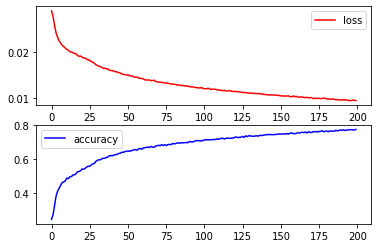

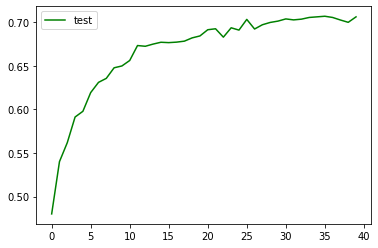

epoch 0: loss: 0.009347, train accuracy: 0.777875
epoch 1: loss: 0.009300, train accuracy: 0.777631
epoch 2: loss: 0.009293, train accuracy: 0.776586
epoch 3: loss: 0.009302, train accuracy: 0.776864
epoch 4: loss: 0.009337, train accuracy: 0.775367
test accuracy: 0.7061855670103093


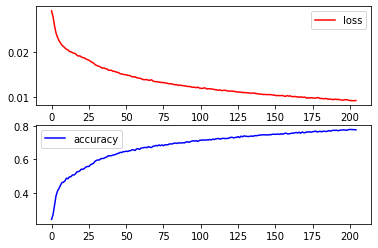

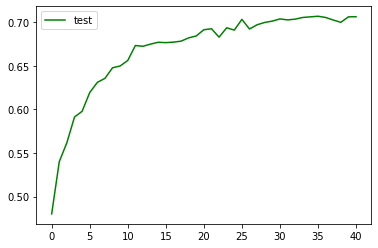

epoch 0: loss: 0.009341, train accuracy: 0.777422
epoch 1: loss: 0.009270, train accuracy: 0.778502
epoch 2: loss: 0.009223, train accuracy: 0.780452
epoch 3: loss: 0.009235, train accuracy: 0.780382
epoch 4: loss: 0.009230, train accuracy: 0.779233
test accuracy: 0.700752298690443


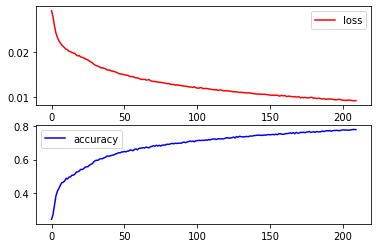

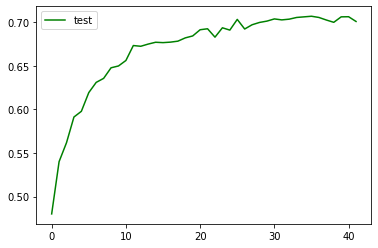

epoch 0: loss: 0.009163, train accuracy: 0.778745
epoch 1: loss: 0.009274, train accuracy: 0.779128
epoch 2: loss: 0.009142, train accuracy: 0.782612
epoch 3: loss: 0.009073, train accuracy: 0.786826
epoch 4: loss: 0.009039, train accuracy: 0.784388
test accuracy: 0.703956533853441


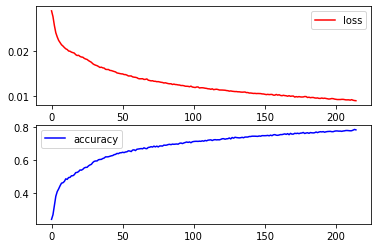

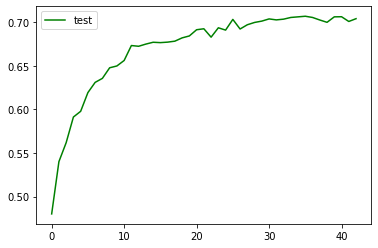

epoch 0: loss: 0.009069, train accuracy: 0.783587
epoch 1: loss: 0.009019, train accuracy: 0.782821
epoch 2: loss: 0.009048, train accuracy: 0.784562
epoch 3: loss: 0.009084, train accuracy: 0.782856
epoch 4: loss: 0.008889, train accuracy: 0.790101
test accuracy: 0.7053496795764836


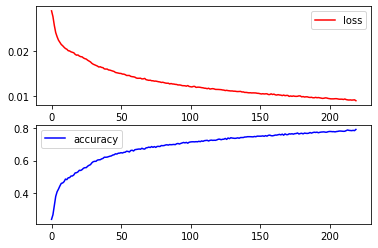

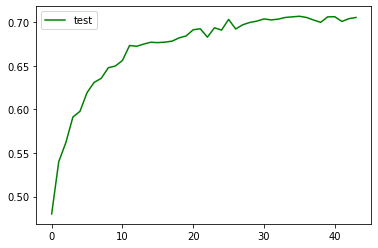

epoch 0: loss: 0.008949, train accuracy: 0.786617
epoch 1: loss: 0.009030, train accuracy: 0.787279
epoch 2: loss: 0.008998, train accuracy: 0.786095
epoch 3: loss: 0.008944, train accuracy: 0.787697
epoch 4: loss: 0.009003, train accuracy: 0.785538
test accuracy: 0.7073000835887434


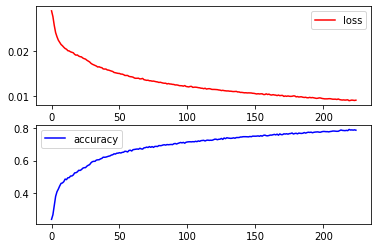

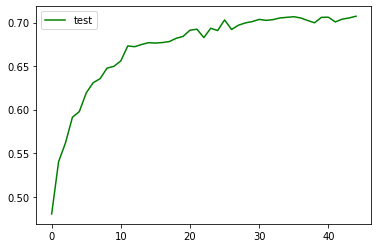

epoch 0: loss: 0.008922, train accuracy: 0.786060
epoch 1: loss: 0.009027, train accuracy: 0.786304
epoch 2: loss: 0.009060, train accuracy: 0.784632
epoch 3: loss: 0.008944, train accuracy: 0.788847
epoch 4: loss: 0.008886, train accuracy: 0.789195
test accuracy: 0.7079966564502647


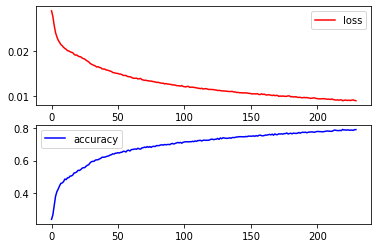

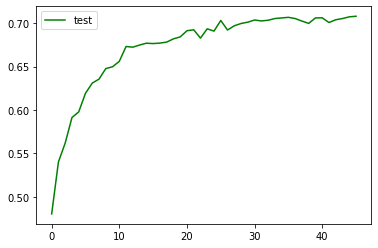

epoch 0: loss: 0.008827, train accuracy: 0.788847
epoch 1: loss: 0.008752, train accuracy: 0.789300
epoch 2: loss: 0.008778, train accuracy: 0.791842
epoch 3: loss: 0.008796, train accuracy: 0.790379
epoch 4: loss: 0.008722, train accuracy: 0.792678
test accuracy: 0.7105043187517415


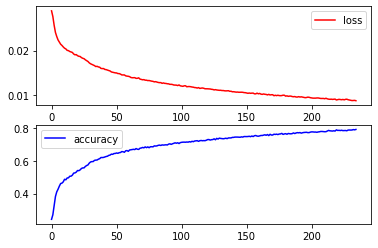

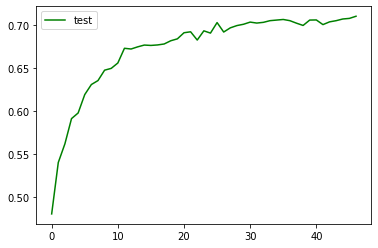

epoch 0: loss: 0.008700, train accuracy: 0.795151
epoch 1: loss: 0.008734, train accuracy: 0.791111
epoch 2: loss: 0.008710, train accuracy: 0.794699
epoch 3: loss: 0.008712, train accuracy: 0.791180
epoch 4: loss: 0.008714, train accuracy: 0.794002
test accuracy: 0.7125940373363053


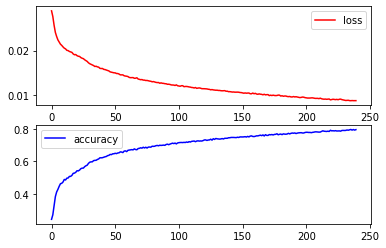

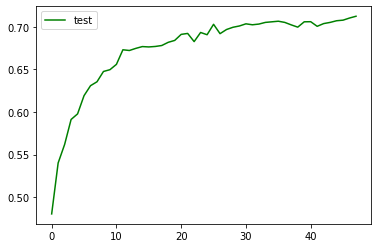

epoch 0: loss: 0.008679, train accuracy: 0.794072
epoch 1: loss: 0.008679, train accuracy: 0.795291
epoch 2: loss: 0.008614, train accuracy: 0.794733
epoch 3: loss: 0.008725, train accuracy: 0.792191
epoch 4: loss: 0.008574, train accuracy: 0.795186
test accuracy: 0.7092504876010031


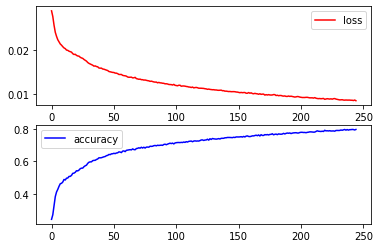

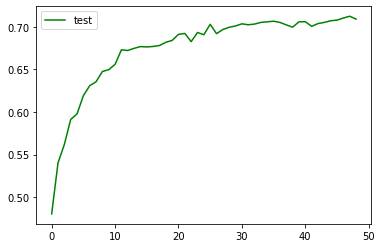

epoch 0: loss: 0.008601, train accuracy: 0.797241
epoch 1: loss: 0.008655, train accuracy: 0.794942
epoch 2: loss: 0.008635, train accuracy: 0.797520
epoch 3: loss: 0.008546, train accuracy: 0.796475
epoch 4: loss: 0.008533, train accuracy: 0.795430
test accuracy: 0.7116188353301756


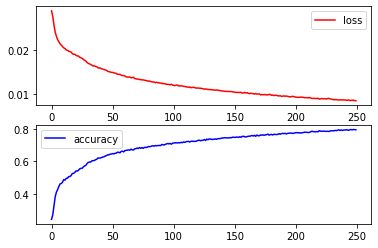

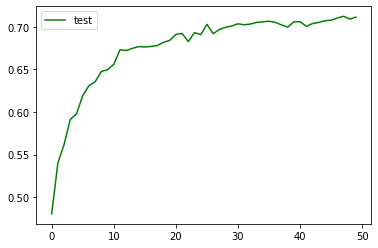

epoch 0: loss: 0.008592, train accuracy: 0.795256
epoch 1: loss: 0.008448, train accuracy: 0.798112
epoch 2: loss: 0.008474, train accuracy: 0.797415
epoch 3: loss: 0.008484, train accuracy: 0.798809
epoch 4: loss: 0.008402, train accuracy: 0.802118
test accuracy: 0.7125940373363053


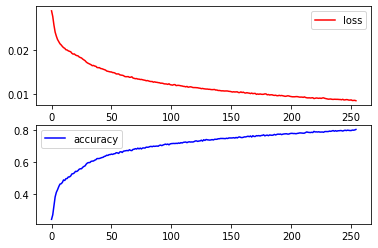

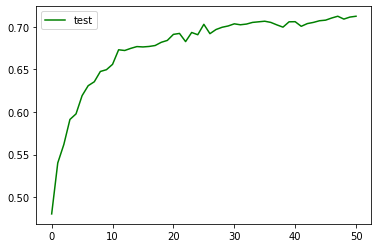

epoch 0: loss: 0.008364, train accuracy: 0.802327
epoch 1: loss: 0.008397, train accuracy: 0.798321
epoch 2: loss: 0.008396, train accuracy: 0.800237
epoch 3: loss: 0.008386, train accuracy: 0.801456
epoch 4: loss: 0.008440, train accuracy: 0.799680
test accuracy: 0.7089718584563945


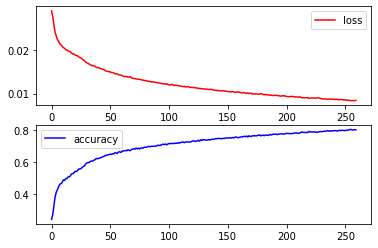

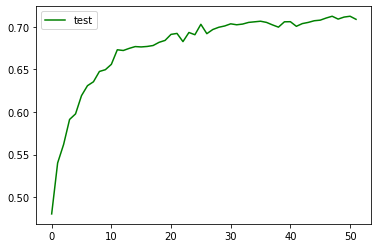

epoch 0: loss: 0.008406, train accuracy: 0.801630
epoch 1: loss: 0.008404, train accuracy: 0.798913
epoch 2: loss: 0.008351, train accuracy: 0.802431
epoch 3: loss: 0.008341, train accuracy: 0.802118
epoch 4: loss: 0.008315, train accuracy: 0.802814
test accuracy: 0.7035385901365283


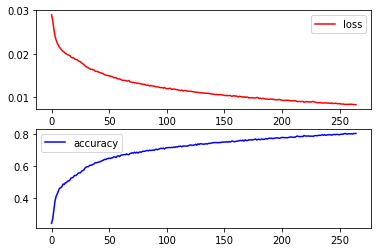

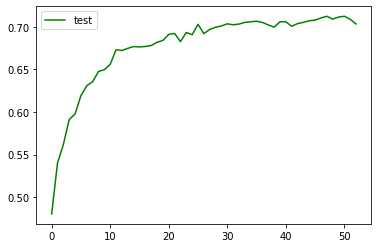

epoch 0: loss: 0.008349, train accuracy: 0.805044
epoch 1: loss: 0.008263, train accuracy: 0.803511
epoch 2: loss: 0.008209, train accuracy: 0.805636
epoch 3: loss: 0.008359, train accuracy: 0.801978
epoch 4: loss: 0.008378, train accuracy: 0.800481
test accuracy: 0.7099470604625244


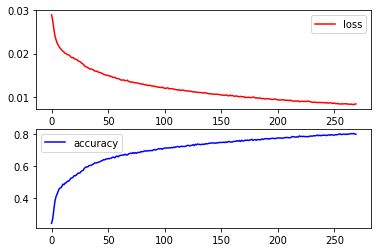

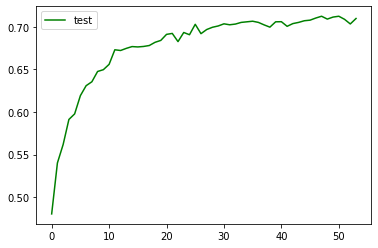

epoch 0: loss: 0.008220, train accuracy: 0.803685
epoch 1: loss: 0.008276, train accuracy: 0.804138
epoch 2: loss: 0.008157, train accuracy: 0.804486
epoch 3: loss: 0.008174, train accuracy: 0.805218
epoch 4: loss: 0.008176, train accuracy: 0.803023
test accuracy: 0.7052103650041794


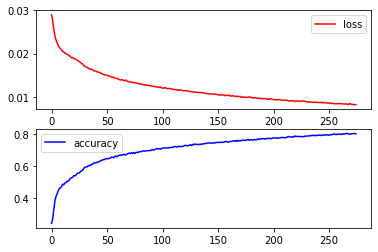

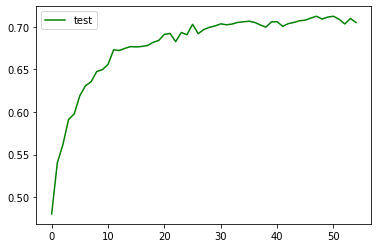

epoch 0: loss: 0.008274, train accuracy: 0.803337
epoch 1: loss: 0.008123, train accuracy: 0.807238
epoch 2: loss: 0.008118, train accuracy: 0.807273
epoch 3: loss: 0.008204, train accuracy: 0.803616
epoch 4: loss: 0.008135, train accuracy: 0.806193
test accuracy: 0.708693229311786


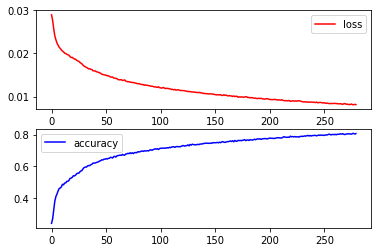

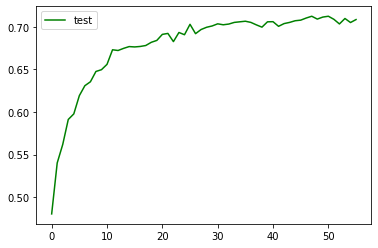

epoch 0: loss: 0.008063, train accuracy: 0.805288
epoch 1: loss: 0.008045, train accuracy: 0.808109
epoch 2: loss: 0.008178, train accuracy: 0.804835
epoch 3: loss: 0.008101, train accuracy: 0.809363
epoch 4: loss: 0.008053, train accuracy: 0.809537
test accuracy: 0.7131512956255224


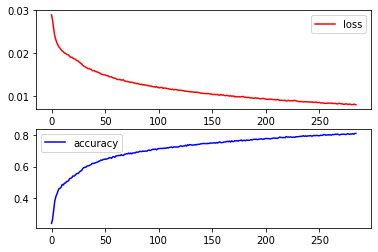

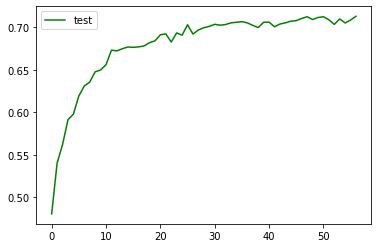

epoch 0: loss: 0.008108, train accuracy: 0.809885
epoch 1: loss: 0.008019, train accuracy: 0.811557
epoch 2: loss: 0.008004, train accuracy: 0.811000
epoch 3: loss: 0.007973, train accuracy: 0.811174
epoch 4: loss: 0.008054, train accuracy: 0.810547
test accuracy: 0.7073000835887434


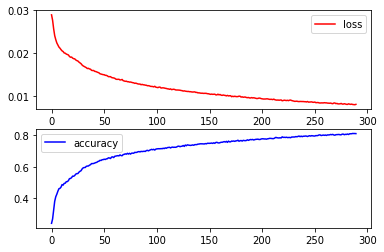

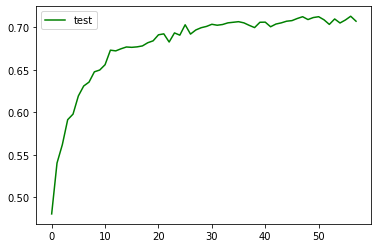

epoch 0: loss: 0.008046, train accuracy: 0.808666
epoch 1: loss: 0.008064, train accuracy: 0.809676
epoch 2: loss: 0.007973, train accuracy: 0.809885
epoch 3: loss: 0.008025, train accuracy: 0.809293
epoch 4: loss: 0.008019, train accuracy: 0.809328
test accuracy: 0.7100863750348286


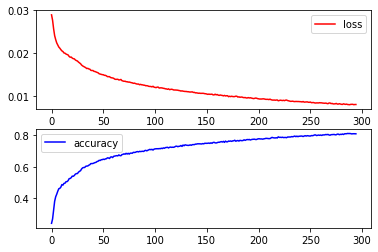

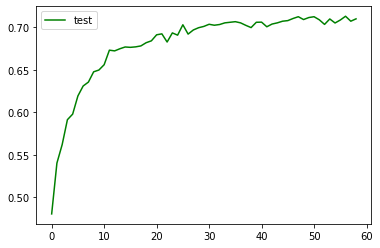

epoch 0: loss: 0.007950, train accuracy: 0.811035
epoch 1: loss: 0.007913, train accuracy: 0.812254
epoch 2: loss: 0.007809, train accuracy: 0.814588
epoch 3: loss: 0.007962, train accuracy: 0.811941
epoch 4: loss: 0.007781, train accuracy: 0.814727
test accuracy: 0.7100863750348286


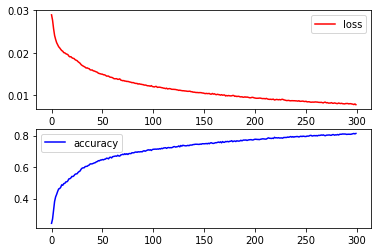

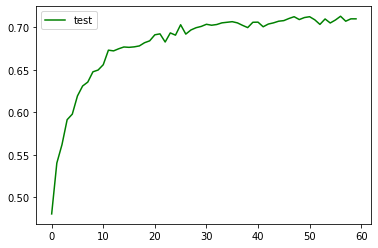

In [ ]:
model = ERNet().to(DEVICE)
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
loss_list_all = []
accuracy_list_all = []
test_list_all = []
for j in range(60):
    ll, al = Train(model, criterion, optimizer, 5)
    loss_list_all += ll
    accuracy_list_all += al
    test_list_all.append(Test(model))
    Draw(loss_list_all, accuracy_list_all, test_list_all)

### GoOn

epoch 0: loss: 0.007273, train accuracy: 0.826675
test accuracy: 0.7096684313179159
epoch 0: loss: 0.007312, train accuracy: 0.828625
test accuracy: 0.710225689607133
epoch 0: loss: 0.007243, train accuracy: 0.828416
test accuracy: 0.7068821398718306
epoch 0: loss: 0.007376, train accuracy: 0.826396
test accuracy: 0.7106436333240457
epoch 0: loss: 0.007149, train accuracy: 0.827998
test accuracy: 0.7116188353301756


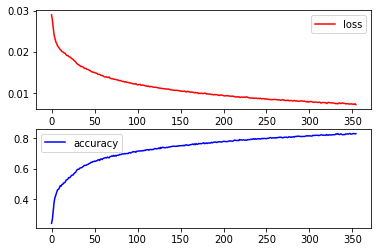

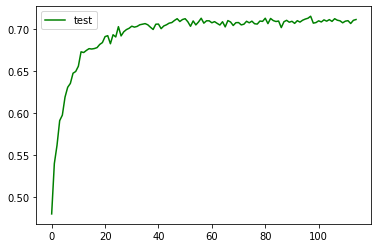

epoch 0: loss: 0.007340, train accuracy: 0.827545
test accuracy: 0.7123154081916968
epoch 0: loss: 0.007214, train accuracy: 0.830820
test accuracy: 0.7050710504318751
epoch 0: loss: 0.007326, train accuracy: 0.827023
test accuracy: 0.7071607690164391
epoch 0: loss: 0.007233, train accuracy: 0.829740
test accuracy: 0.7099470604625244
epoch 0: loss: 0.007272, train accuracy: 0.829252
test accuracy: 0.7127333519086096


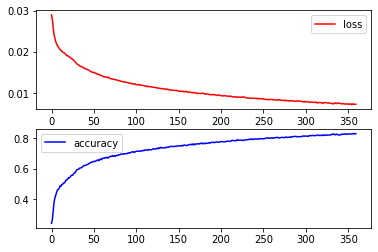

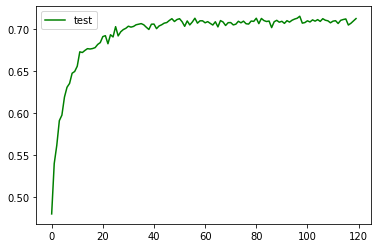

epoch 0: loss: 0.007177, train accuracy: 0.829531
test accuracy: 0.7089718584563945
epoch 0: loss: 0.007322, train accuracy: 0.823923
test accuracy: 0.703956533853441
epoch 0: loss: 0.007293, train accuracy: 0.826570
test accuracy: 0.7063248815826135
epoch 0: loss: 0.007228, train accuracy: 0.829635
test accuracy: 0.7131512956255224
epoch 0: loss: 0.007300, train accuracy: 0.828172
test accuracy: 0.71078294789635


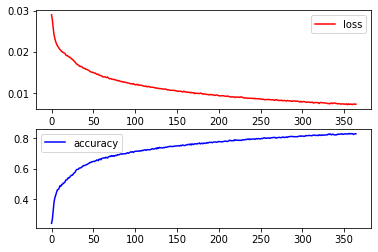

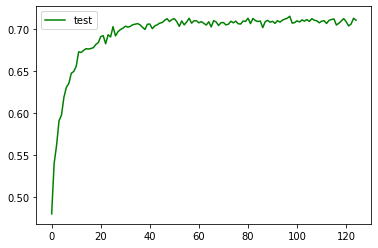

epoch 0: loss: 0.007186, train accuracy: 0.830994
test accuracy: 0.7093898021733074
epoch 0: loss: 0.007099, train accuracy: 0.833258
test accuracy: 0.7082752855948732
epoch 0: loss: 0.007108, train accuracy: 0.830994
test accuracy: 0.7103650041794372
epoch 0: loss: 0.007175, train accuracy: 0.830994
test accuracy: 0.7084146001671775
epoch 0: loss: 0.007148, train accuracy: 0.829113
test accuracy: 0.7146837559208693


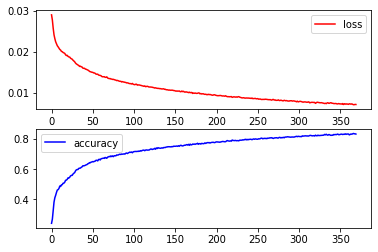

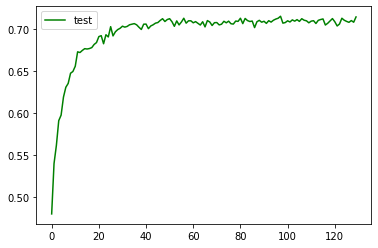

epoch 0: loss: 0.007227, train accuracy: 0.831307
test accuracy: 0.7141264976316523
epoch 0: loss: 0.007080, train accuracy: 0.833885
test accuracy: 0.7130119810532182
epoch 0: loss: 0.007150, train accuracy: 0.829809
test accuracy: 0.706046252438005
epoch 0: loss: 0.007134, train accuracy: 0.834895
test accuracy: 0.7075787127333519
epoch 0: loss: 0.007055, train accuracy: 0.831447
test accuracy: 0.7082752855948732


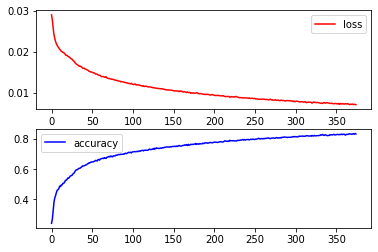

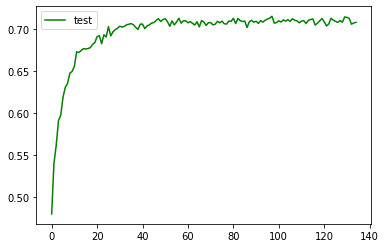

epoch 0: loss: 0.006970, train accuracy: 0.834059
test accuracy: 0.7075787127333519
epoch 0: loss: 0.007213, train accuracy: 0.829844
test accuracy: 0.7091111730286987
epoch 0: loss: 0.007161, train accuracy: 0.833188
test accuracy: 0.7131512956255224
epoch 0: loss: 0.006965, train accuracy: 0.838309
test accuracy: 0.7159375870716077
epoch 0: loss: 0.007186, train accuracy: 0.830123
test accuracy: 0.7112008916132627


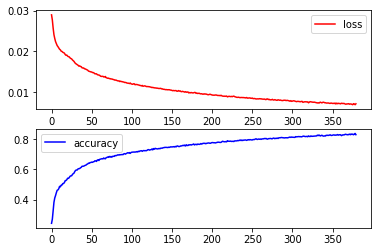

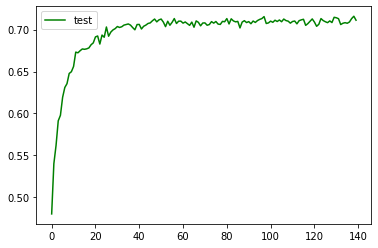

epoch 0: loss: 0.007003, train accuracy: 0.836253
test accuracy: 0.7173307327946503
epoch 0: loss: 0.006971, train accuracy: 0.835104
test accuracy: 0.7079966564502647
epoch 0: loss: 0.007141, train accuracy: 0.832561
test accuracy: 0.7070214544441349
epoch 0: loss: 0.007031, train accuracy: 0.834930
test accuracy: 0.7164948453608248
epoch 0: loss: 0.007060, train accuracy: 0.832422
test accuracy: 0.7116188353301756


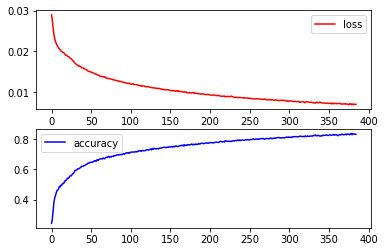

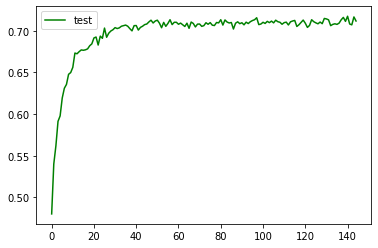

epoch 0: loss: 0.006970, train accuracy: 0.833711
test accuracy: 0.7114795207578712
epoch 0: loss: 0.006996, train accuracy: 0.833049
test accuracy: 0.7095291167456116
epoch 0: loss: 0.006909, train accuracy: 0.838134
test accuracy: 0.711340206185567
epoch 0: loss: 0.006901, train accuracy: 0.840259
test accuracy: 0.7092504876010031
test accuracy: 0.7100863750348286


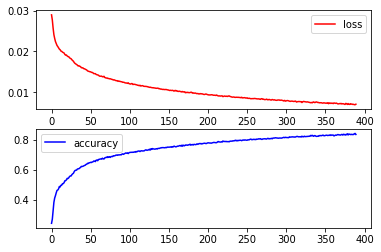

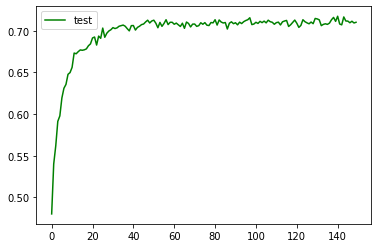

epoch 0: loss: 0.006896, train accuracy: 0.836950
test accuracy: 0.7105043187517415
epoch 0: loss: 0.007101, train accuracy: 0.833362
test accuracy: 0.7142658122039566
epoch 0: loss: 0.006881, train accuracy: 0.838727
test accuracy: 0.7110615770409585
epoch 0: loss: 0.006868, train accuracy: 0.839005
test accuracy: 0.7088325438840902
epoch 0: loss: 0.006961, train accuracy: 0.835626
test accuracy: 0.7109222624686542


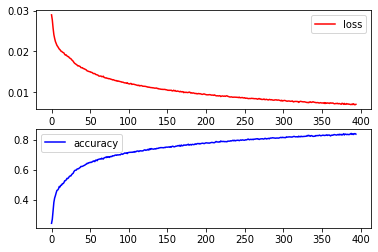

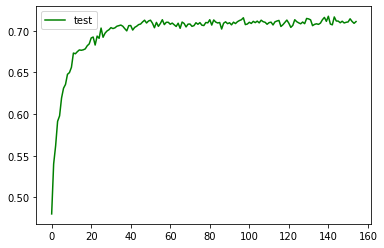

epoch 0: loss: 0.006925, train accuracy: 0.835208
test accuracy: 0.7075787127333519
epoch 0: loss: 0.006999, train accuracy: 0.833955
test accuracy: 0.7085539147394817
epoch 0: loss: 0.006955, train accuracy: 0.835487
test accuracy: 0.7148230704931736
epoch 0: loss: 0.006904, train accuracy: 0.836776
test accuracy: 0.7118974644747841
epoch 0: loss: 0.006994, train accuracy: 0.836428
test accuracy: 0.7152410142100863


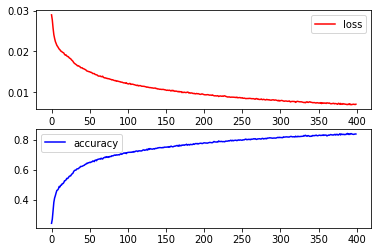

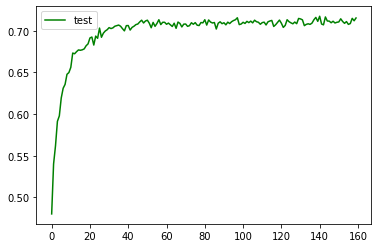

In [ ]:
max = 0.716
for j in range(10):
    for i in range(5):
        ll, al = Train(model, criterion, optimizer, 1)
        loss_list_all += ll
        accuracy_list_all += al
        ta = Test(model)
        if ta > max:
            torch.save(model, "/content/drive/MyDrive/code/max.pkl")
            max = ta
        test_list_all.append(ta)
    Draw(loss_list_all, accuracy_list_all, test_list_all)

### GoOn

epoch 0: loss: 0.007029, train accuracy: 0.834059
test accuracy: 0.7130119810532182
epoch 0: loss: 0.006839, train accuracy: 0.841513
test accuracy: 0.7142658122039566
epoch 0: loss: 0.006873, train accuracy: 0.837751
test accuracy: 0.7191418222346058
epoch 0: loss: 0.006914, train accuracy: 0.835696
test accuracy: 0.7109222624686542
epoch 0: loss: 0.006778, train accuracy: 0.841792
test accuracy: 0.7141264976316523


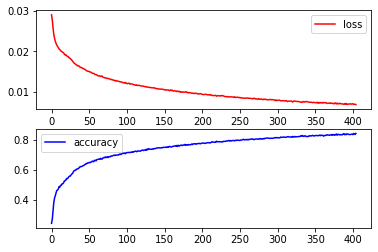

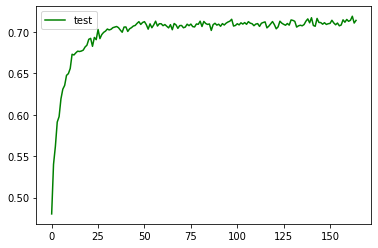

epoch 0: loss: 0.006844, train accuracy: 0.839179
test accuracy: 0.7124547227640011
epoch 0: loss: 0.006826, train accuracy: 0.839423
test accuracy: 0.7109222624686542
epoch 0: loss: 0.006883, train accuracy: 0.836428
test accuracy: 0.7208135971022569
epoch 0: loss: 0.006866, train accuracy: 0.837333
test accuracy: 0.7155196433546949
epoch 0: loss: 0.006801, train accuracy: 0.838761
test accuracy: 0.7156589579269992


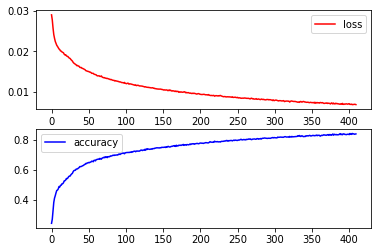

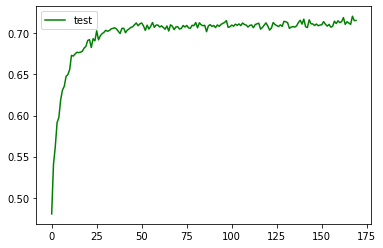

epoch 0: loss: 0.006786, train accuracy: 0.841374
test accuracy: 0.7123154081916968
epoch 0: loss: 0.006873, train accuracy: 0.838239
test accuracy: 0.7117581499024798
epoch 0: loss: 0.006734, train accuracy: 0.843742
test accuracy: 0.7103650041794372
epoch 0: loss: 0.006733, train accuracy: 0.841792
test accuracy: 0.7091111730286987
epoch 0: loss: 0.006873, train accuracy: 0.839493
test accuracy: 0.7114795207578712


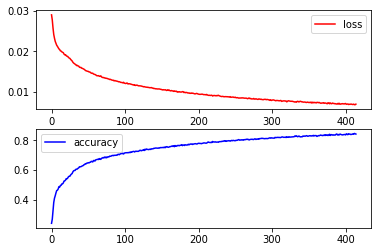

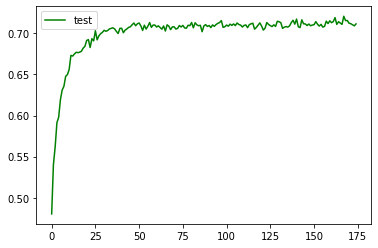

epoch 0: loss: 0.006754, train accuracy: 0.841513
test accuracy: 0.7106436333240457
epoch 0: loss: 0.006724, train accuracy: 0.841095
test accuracy: 0.7116188353301756
epoch 0: loss: 0.006615, train accuracy: 0.842872
test accuracy: 0.7149623850654778
epoch 0: loss: 0.006775, train accuracy: 0.842001
test accuracy: 0.7153803287823907
epoch 0: loss: 0.006850, train accuracy: 0.837507
test accuracy: 0.713987183059348


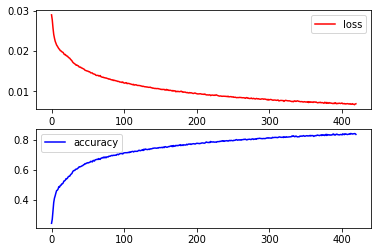

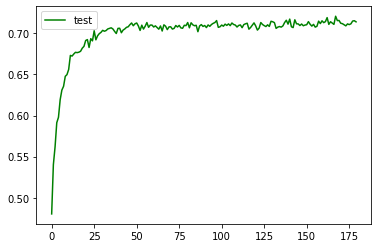

epoch 0: loss: 0.006787, train accuracy: 0.840050
test accuracy: 0.7121760936193926
epoch 0: loss: 0.006742, train accuracy: 0.842558
test accuracy: 0.7117581499024798
epoch 0: loss: 0.006679, train accuracy: 0.841200
test accuracy: 0.7077180273056561
epoch 0: loss: 0.006748, train accuracy: 0.839354
test accuracy: 0.7141264976316523
epoch 0: loss: 0.006788, train accuracy: 0.841896
test accuracy: 0.7130119810532182


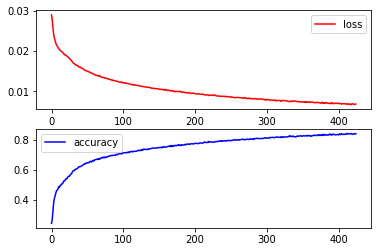

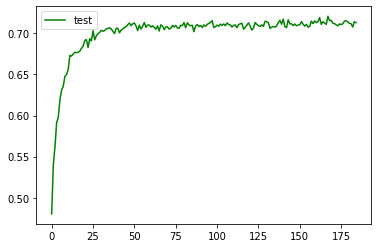

epoch 0: loss: 0.006757, train accuracy: 0.840155
test accuracy: 0.7155196433546949
epoch 0: loss: 0.006756, train accuracy: 0.840433
test accuracy: 0.7112008916132627
epoch 0: loss: 0.006658, train accuracy: 0.843812
test accuracy: 0.7125940373363053
epoch 0: loss: 0.006728, train accuracy: 0.841827
test accuracy: 0.7118974644747841
epoch 0: loss: 0.006799, train accuracy: 0.841339
test accuracy: 0.7121760936193926


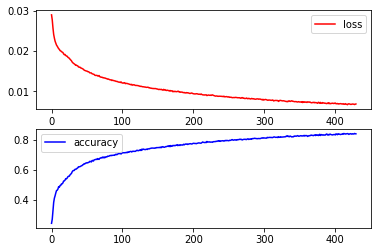

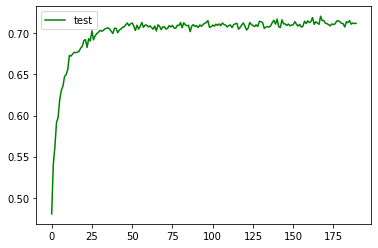

epoch 0: loss: 0.006677, train accuracy: 0.843046
test accuracy: 0.7130119810532182
epoch 0: loss: 0.006661, train accuracy: 0.843046
test accuracy: 0.7125940373363053
epoch 0: loss: 0.006650, train accuracy: 0.841931
test accuracy: 0.7073000835887434
epoch 0: loss: 0.006708, train accuracy: 0.843951
test accuracy: 0.7121760936193926
epoch 0: loss: 0.006548, train accuracy: 0.846599
test accuracy: 0.7148230704931736


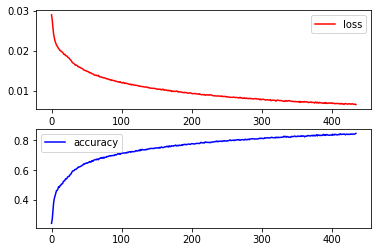

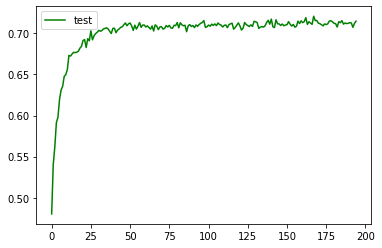

epoch 0: loss: 0.006547, train accuracy: 0.845902
test accuracy: 0.713429924770131
epoch 0: loss: 0.006657, train accuracy: 0.845101
test accuracy: 0.7085539147394817
epoch 0: loss: 0.006575, train accuracy: 0.847435
test accuracy: 0.7084146001671775
epoch 0: loss: 0.006713, train accuracy: 0.843568
test accuracy: 0.7120367790470883
epoch 0: loss: 0.006578, train accuracy: 0.847017
test accuracy: 0.7091111730286987


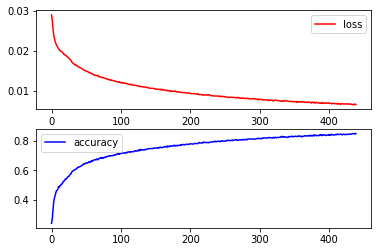

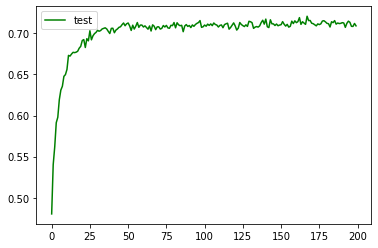

epoch 0: loss: 0.006675, train accuracy: 0.846006
test accuracy: 0.7116188353301756
epoch 0: loss: 0.006640, train accuracy: 0.845275
test accuracy: 0.7123154081916968
epoch 0: loss: 0.006669, train accuracy: 0.843290
test accuracy: 0.7106436333240457
epoch 0: loss: 0.006584, train accuracy: 0.846842
test accuracy: 0.7071607690164391
epoch 0: loss: 0.006617, train accuracy: 0.845484
test accuracy: 0.7100863750348286


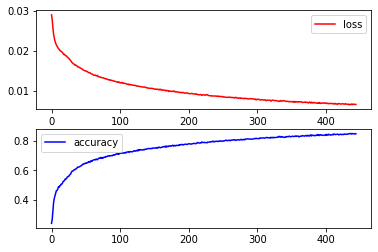

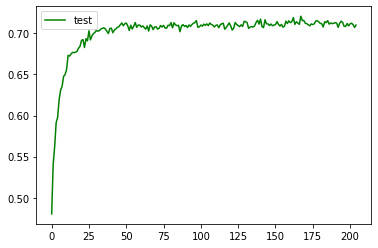

epoch 0: loss: 0.006507, train accuracy: 0.847051
test accuracy: 0.7128726664809139
epoch 0: loss: 0.006552, train accuracy: 0.846181
test accuracy: 0.7121760936193926
epoch 0: loss: 0.006513, train accuracy: 0.845937
test accuracy: 0.7135692393424352
epoch 0: loss: 0.006606, train accuracy: 0.843603
test accuracy: 0.7099470604625244
epoch 0: loss: 0.006581, train accuracy: 0.844404
test accuracy: 0.7071607690164391


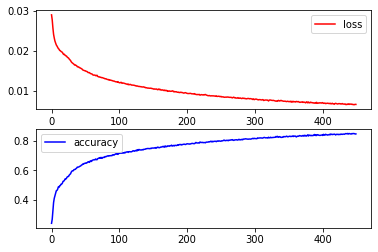

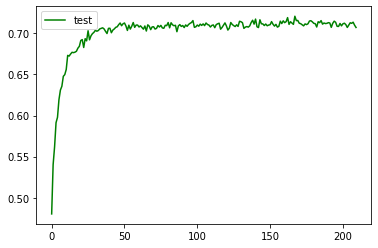

In [ ]:
for j in range(10):
    for i in range(5):
        ll, al = Train(model, criterion, optimizer, 1)
        loss_list_all += ll
        accuracy_list_all += al
        ta = Test(model)
        if ta > max:
            torch.save(model, "/content/drive/MyDrive/code/max.pkl")
            max = ta
        test_list_all.append(ta)
    Draw(loss_list_all, accuracy_list_all, test_list_all)

### GoOn

epoch 0: loss: 0.006544, train accuracy: 0.849037
test accuracy: 0.7098077458902201
epoch 0: loss: 0.006580, train accuracy: 0.846912
test accuracy: 0.7064641961549178
epoch 0: loss: 0.006619, train accuracy: 0.845763
test accuracy: 0.7098077458902201
epoch 0: loss: 0.006696, train accuracy: 0.841896
test accuracy: 0.7137085539147395
epoch 0: loss: 0.006528, train accuracy: 0.846390
test accuracy: 0.7123154081916968


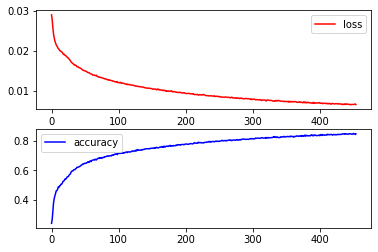

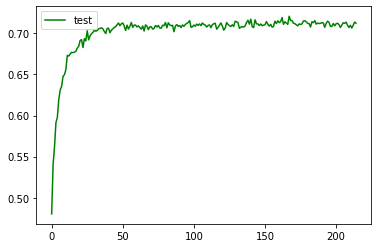

epoch 0: loss: 0.006444, train accuracy: 0.850117
test accuracy: 0.708135971022569
epoch 0: loss: 0.006569, train accuracy: 0.844160
test accuracy: 0.7079966564502647
epoch 0: loss: 0.006551, train accuracy: 0.846947
test accuracy: 0.708135971022569
epoch 0: loss: 0.006536, train accuracy: 0.849768
test accuracy: 0.7098077458902201
epoch 0: loss: 0.006487, train accuracy: 0.845728
test accuracy: 0.7100863750348286


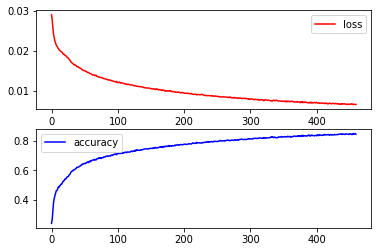

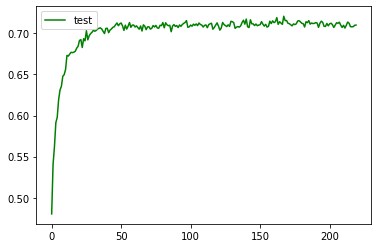

epoch 0: loss: 0.006374, train accuracy: 0.851162
test accuracy: 0.7093898021733074
epoch 0: loss: 0.006376, train accuracy: 0.849316
test accuracy: 0.7091111730286987
epoch 0: loss: 0.006417, train accuracy: 0.848619
test accuracy: 0.7120367790470883
epoch 0: loss: 0.006407, train accuracy: 0.849107
test accuracy: 0.7063248815826135
epoch 0: loss: 0.006529, train accuracy: 0.848305
test accuracy: 0.7100863750348286


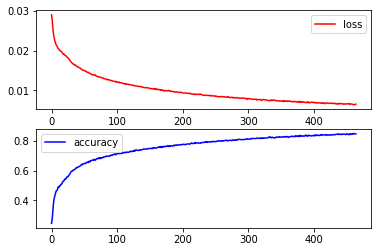

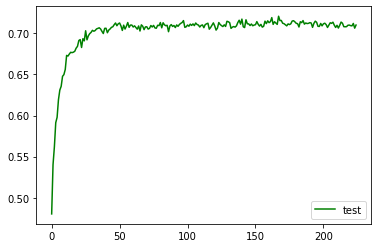

epoch 0: loss: 0.006479, train accuracy: 0.847017
test accuracy: 0.71078294789635
epoch 0: loss: 0.006324, train accuracy: 0.854645
test accuracy: 0.7017275006965729
epoch 0: loss: 0.006327, train accuracy: 0.850535
test accuracy: 0.706603510727222
epoch 0: loss: 0.006590, train accuracy: 0.843742
test accuracy: 0.7124547227640011
epoch 0: loss: 0.006268, train accuracy: 0.851614
test accuracy: 0.7109222624686542


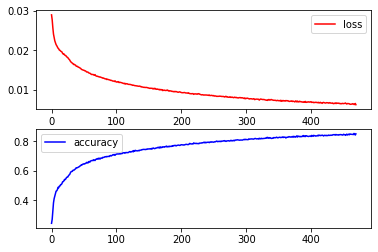

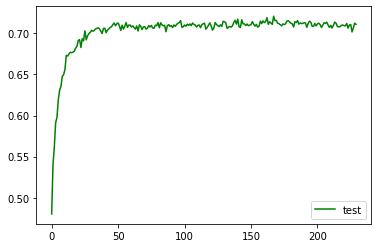

epoch 0: loss: 0.006303, train accuracy: 0.851614
test accuracy: 0.7075787127333519
epoch 0: loss: 0.006427, train accuracy: 0.849838
test accuracy: 0.7092504876010031
epoch 0: loss: 0.006391, train accuracy: 0.849141
test accuracy: 0.7077180273056561
epoch 0: loss: 0.006354, train accuracy: 0.852555
test accuracy: 0.7068821398718306
epoch 0: loss: 0.006360, train accuracy: 0.852450
test accuracy: 0.7137085539147395


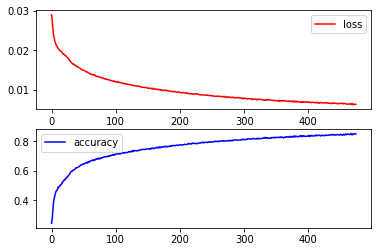

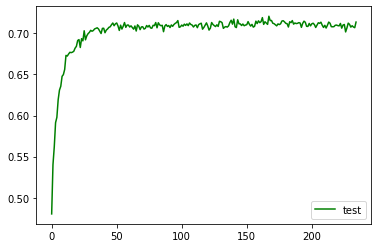

epoch 0: loss: 0.006445, train accuracy: 0.848967
test accuracy: 0.7160769016439119
epoch 0: loss: 0.006371, train accuracy: 0.850047
test accuracy: 0.7110615770409585
epoch 0: loss: 0.006298, train accuracy: 0.851754
test accuracy: 0.7091111730286987
epoch 0: loss: 0.006414, train accuracy: 0.850570
test accuracy: 0.7121760936193926
epoch 0: loss: 0.006437, train accuracy: 0.849350
test accuracy: 0.7074393981610476


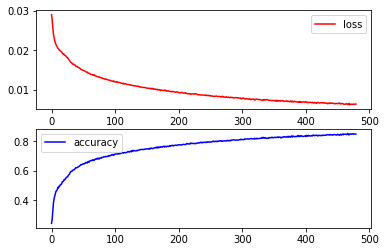

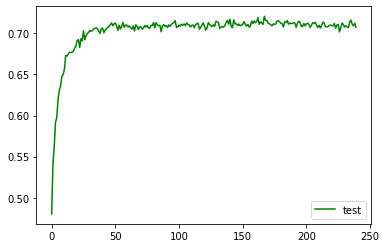

epoch 0: loss: 0.006412, train accuracy: 0.851963
test accuracy: 0.7103650041794372
epoch 0: loss: 0.006308, train accuracy: 0.852938
test accuracy: 0.7116188353301756
epoch 0: loss: 0.006247, train accuracy: 0.854749
test accuracy: 0.7079966564502647
epoch 0: loss: 0.006384, train accuracy: 0.848898
test accuracy: 0.703956533853441
epoch 0: loss: 0.006344, train accuracy: 0.850709
test accuracy: 0.7131512956255224


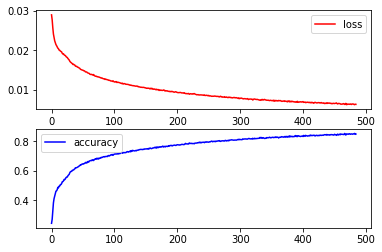

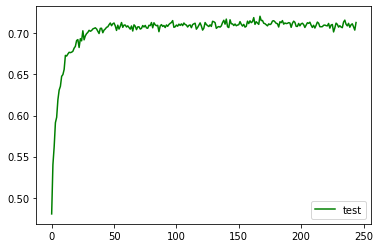

epoch 0: loss: 0.006321, train accuracy: 0.850256
test accuracy: 0.7116188353301756
epoch 0: loss: 0.006244, train accuracy: 0.855551
test accuracy: 0.7091111730286987
epoch 0: loss: 0.006266, train accuracy: 0.854018
test accuracy: 0.7132906101978267
epoch 0: loss: 0.006271, train accuracy: 0.853391
test accuracy: 0.7112008916132627
epoch 0: loss: 0.006370, train accuracy: 0.850186
test accuracy: 0.7156589579269992


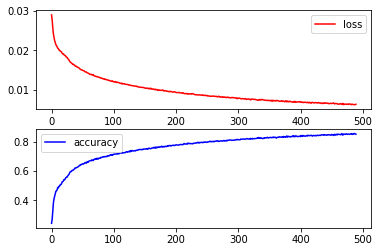

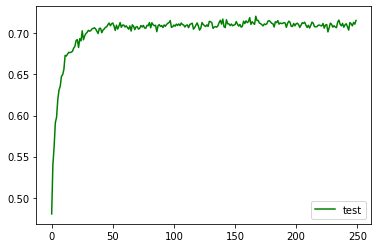

epoch 0: loss: 0.006317, train accuracy: 0.853495
test accuracy: 0.7141264976316523
epoch 0: loss: 0.006251, train accuracy: 0.852729
test accuracy: 0.7120367790470883
epoch 0: loss: 0.006235, train accuracy: 0.855133
test accuracy: 0.7109222624686542
epoch 0: loss: 0.006165, train accuracy: 0.855829
test accuracy: 0.7125940373363053
epoch 0: loss: 0.006235, train accuracy: 0.853948
test accuracy: 0.713987183059348


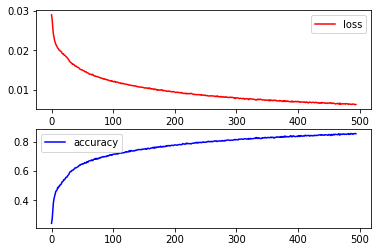

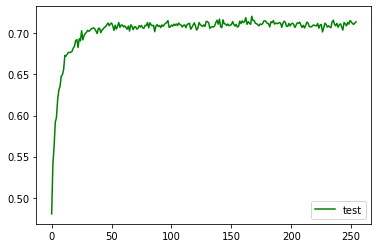

epoch 0: loss: 0.006320, train accuracy: 0.851092
test accuracy: 0.7144051267762608
epoch 0: loss: 0.006296, train accuracy: 0.852172
test accuracy: 0.71078294789635
epoch 0: loss: 0.006256, train accuracy: 0.852450
test accuracy: 0.7095291167456116
epoch 0: loss: 0.006286, train accuracy: 0.853286
test accuracy: 0.7103650041794372
epoch 0: loss: 0.006258, train accuracy: 0.853217
test accuracy: 0.713429924770131


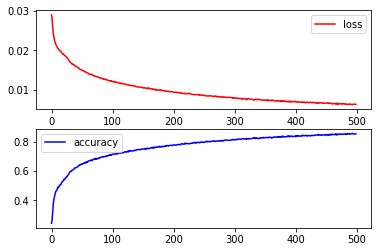

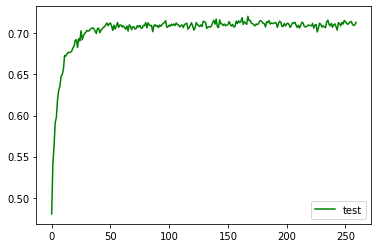

In [ ]:
for j in range(10):
    for i in range(5):
        ll, al = Train(model, criterion, optimizer, 1)
        loss_list_all += ll
        accuracy_list_all += al
        ta = Test(model)
        if ta > max:
            torch.save(model, "/content/drive/MyDrive/code/max.pkl")
            max = ta
        test_list_all.append(ta)
    Draw(loss_list_all, accuracy_list_all, test_list_all)

In [ ]:
print(max)

0.7208135971022569


### Save

In [ ]:
torch.save(model, "/content/drive/MyDrive/code/temp.pkl")

### Eval

In [45]:
def Eval(model_file, test_loader):
    model = torch.load(model_file, map_location=torch.device(DEVICE))
    # mode
    model.eval()
    # label and pred
    label_all = np.array([])
    pred_all = np.array([])

    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)
            output = model(data)
            pred = torch.argmax(output, dim=1)
            # append
            label_all = np.append(label_all, label.cpu().numpy())
            pred_all = np.append(pred_all, pred.cpu().numpy())

    cm = confusion_matrix(label_all, pred_all)
    labels_name = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    ConfusionMatrixDisplay(cm, display_labels=labels_name).plot(xticks_rotation=45)
    print('accuracy_score', accuracy_score(label_all, pred_all))
    print('balanced_accuracy_score', balanced_accuracy_score(label_all, pred_all))
    print('classification_report\n', classification_report(label_all, pred_all, target_names=labels_name, digits=3))

accuracy_score 0.7208135971022569
balanced_accuracy_score 0.710079440907011
classification_report
               precision    recall  f1-score   support

       Angry      0.698     0.597     0.643       958
     Disgust      0.838     0.748     0.790       111
        Fear      0.668     0.510     0.578      1024
       Happy      0.871     0.901     0.886      1774
         Sad      0.595     0.624     0.609      1247
    Surprise      0.824     0.848     0.836       831
     Neutral      0.619     0.743     0.675      1233

    accuracy                          0.721      7178
   macro avg      0.730     0.710     0.717      7178
weighted avg      0.722     0.721     0.718      7178



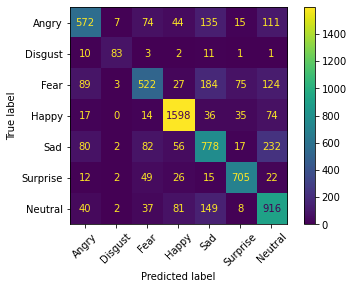

In [46]:
Eval('/content/drive/MyDrive/code/max.pkl', loader_test)